# Predictive Analysis

In [1]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
from matplotlib import pyplot
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn import tree
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
import graphviz

plt.rcParams["figure.figsize"] = (10,12)

In [2]:
weather=pd.read_csv('../data/weather.csv')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.set_index("date_time", inplace=True)
weather.head()

,max_temp,min_temp,precip
date_time,,,
2018-01-01 00:00:00,14.4,14.150,0.0
2018-01-01 01:00:00,14.4,14.275,0.0
2018-01-01 02:00:00,14.4,14.400,0.0
2018-01-01 03:00:00,14.4,14.400,0.0
2018-01-01 04:00:00,14.4,13.900,0.0


In [3]:
df_la=pd.read_csv('../data/LA.csv')
df_la["start_time"] = pd.to_datetime(df_la['start_time'])
df_la["end_time"] = pd.to_datetime(df_la['end_time'] ) 
df_la["trip_duration"] = pd.to_timedelta(df_la.trip_duration)
df_la.set_index("start_time", inplace=True)
df_la.head()

,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_duration,trip_duration_in_hours
start_time,,,,,,,,,
2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,Pershing Square,Grand & Olympic,0 days 00:21:00,0.350000
2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,Pershing Square,Grand & Olympic,0 days 00:20:00,0.333333
2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,Pershing Square,Grand & Olympic,0 days 00:19:00,0.316667
2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,Grand & Olympic,7th & Spring,0 days 00:22:00,0.366667
2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,Washington & Abbot Kinney,17th St / SMC E Line Station,0 days 00:45:00,0.750000


## Feature Engineering

In the first part of the predictive analysis, we create a set of featured that we expect to be correlated with the dependent variable for total system-level demand per hour. <br><br>
We define the total system-level demand as the number distince bikes rented in the respective hour. We assume that temperature and precipitation are correlated with the dependent variable demand, since the descriptive analysis shows that fewer bikes are rented in hours with precipitation and hours with high temperatures. 

In [4]:
#use weather data
df = weather.copy()

# calc demand
df["demand"] = df_la.bike_id.resample("H").count()
df

,max_temp,min_temp,precip,demand
date_time,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25
2018-01-01 01:00:00,14.4,14.275,0.0,24
2018-01-01 02:00:00,14.4,14.400,0.0,12
2018-01-01 03:00:00,14.4,14.400,0.0,3
2018-01-01 04:00:00,14.4,13.900,0.0,4
...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13
2018-12-31 20:00:00,17.8,17.800,0.0,17
2018-12-31 21:00:00,16.7,16.700,0.0,26


We also include the time and date features of season, weekend, and time of day. We assume that these characteristics are correlated with demand because the descriptive analysis showed that bike demand differs across these time periods. To reduce the number of variables for time of day, we divide the day into six hourly intervals. We define weekends as Friday through Sunday because our clustering analysis shows similar demand patterns on these three days. 

In [5]:
# time, date features

#season 
df["season"] = df.index.month%12 // 3 + 1 
dummies = pd.get_dummies(df["season"]).rename(columns=lambda x: "season_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["season"], inplace=True, axis=1)

#weekend or not
df["day_of_week"] = df.index.day_of_week
df["weekend"] = df.day_of_week.apply(lambda x: 1 if x >=4 else 0) #friday till sunday
df.drop("day_of_week", inplace=True, axis=1)

#time of wad
df["hour"] = df.index.hour 
df["time_of_day"] = df.hour.apply(lambda x: (x-1)//6 if x>0 else 3)
dummies = pd.get_dummies(df["time_of_day"]).rename(columns=lambda x: "time_of_day_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["time_of_day"], inplace=True, axis=1)
df.drop(["hour"], inplace=True, axis=1)

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
date_time,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,1,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,1,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,1,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,1


We use an interaction variable of the time of day and the weekend indicator to account for the different demand pattern over the course of a day on weekdays compared to weekends, as identified in the cluster analysis.

In [6]:
#interaction features: time of day x weekend

df["time_of_day_0_x_weekend"] = df.time_of_day_0 * df.weekend
df["time_of_day_1_x_weekend"] = df.time_of_day_1 * df.weekend
df["time_of_day_2_x_weekend"] = df.time_of_day_2 * df.weekend
df["time_of_day_3_x_weekend"] = df.time_of_day_3 * df.weekend

df["time_of_day_0_x_not_weekend"] = df.time_of_day_0 * (1-df.weekend)
df["time_of_day_1_x_not_weekend"] = df.time_of_day_1 * (1-df.weekend)
df["time_of_day_2_x_not_weekend"] = df.time_of_day_2 * (1-df.weekend)
df["time_of_day_3_x_not_weekend"] = df.time_of_day_3 * (1-df.weekend)

df.drop(["time_of_day_0","time_of_day_1","time_of_day_2","time_of_day_3"], inplace=True, axis=1)

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,time_of_day_1_x_weekend,time_of_day_2_x_weekend,time_of_day_3_x_weekend,time_of_day_0_x_not_weekend,time_of_day_1_x_not_weekend,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend
date_time,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,0,0,0,0,1


Since the number of rentals is particularly high during the hours when the "CicLAvia" event takes place, we expect the indicator variable for this event to be strongly correlated with our demand variable.

In [7]:
#special days: metro event
df['event'] = 0
df.loc['2018-04-22 08:00:00':'2018-04-22 15:00:00','event'] = 1
df.loc['2018-09-30 08:00:00':'2018-09-30 15:00:00','event'] = 1
df.loc['2018-12-02 09:00:00':'2018-12-02 15:00:00','event'] = 1

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,time_of_day_1_x_weekend,time_of_day_2_x_weekend,time_of_day_3_x_weekend,time_of_day_0_x_not_weekend,time_of_day_1_x_not_weekend,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend,event
date_time,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,0,0,0,0,1,0


Since out dataset is time series data we expect similar demand for hours that lie close together. To ensure that all data is available to forecast total system-level demand in the next hour, we do not use demand from the hour prior to that respective.  <br>
The demand variable lagged by 24 hours is also included, as we assume that demand at the same hour on the previous day is similar to the respective hour.

In [8]:
#past demand

#lag features
df["lag_2"] = df.demand.shift(2)
df["lag_3"] = df.demand.shift(3)
df["lag_4"] = df.demand.shift(4)

df["lag_22"] = df.demand.shift(22)
df["lag_23"] = df.demand.shift(23)
df["lag_24"] = df.demand.shift(24) 

#rolling average 
df["rolling_avg"] = df.lag_2.rolling(22).mean()

df.dropna(inplace=True)
df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,...,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend,event,lag_2,lag_3,lag_4,lag_22,lag_23,lag_24,rolling_avg
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,16.1,16.1,0.0,6,1,0,0,0,0,0,...,0,1,0,4.0,11.0,29.0,12.0,24.0,25.0,32.818182
2018-01-02 01:00:00,15.6,15.6,0.0,7,1,0,0,0,0,0,...,0,0,0,10.0,4.0,11.0,3.0,12.0,24.0,32.181818
2018-01-02 02:00:00,15.6,15.0,0.0,1,1,0,0,0,0,0,...,0,0,0,6.0,10.0,4.0,4.0,3.0,12.0,31.909091
2018-01-02 03:00:00,15.6,15.6,0.0,0,1,0,0,0,0,0,...,0,0,0,7.0,6.0,10.0,7.0,4.0,3.0,32.090909
2018-01-02 04:00:00,15.0,15.0,0.0,0,1,0,0,0,0,0,...,0,0,0,1.0,7.0,6.0,13.0,7.0,4.0,31.954545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.7,0.0,13,1,0,0,0,0,0,...,0,1,0,36.0,61.0,67.0,9.0,19.0,26.0,24.045455
2018-12-31 20:00:00,17.8,17.8,0.0,17,1,0,0,0,0,0,...,0,1,0,25.0,36.0,61.0,4.0,9.0,19.0,24.318182
2018-12-31 21:00:00,16.7,16.7,0.0,26,1,0,0,0,0,0,...,0,1,0,13.0,25.0,36.0,8.0,4.0,9.0,24.500000


We plot our created features in a heatmap to evaluate their correlation with the dependent variable.<br>
The heatmap shows a strong positive correlation between demand and the lag variables as well as demand and the midday indicators. Demand is negatively correlated with the night indicators.  

<AxesSubplot:>

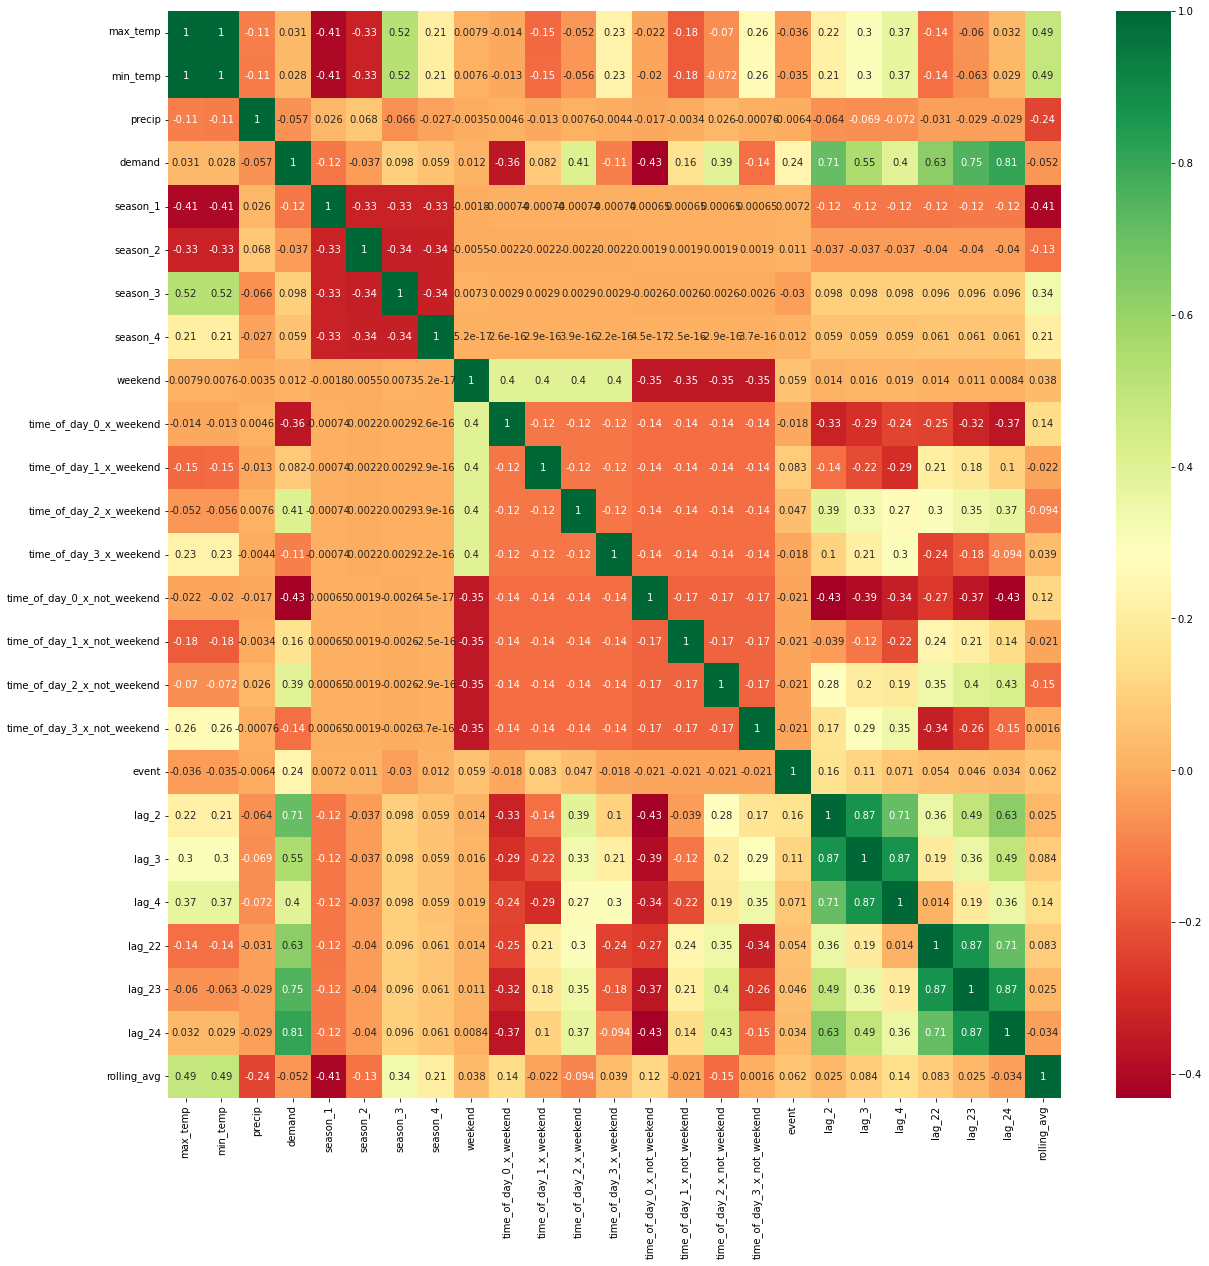

In [9]:
#test feature correlation with demand
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model Building

We split the data set into a training set and a test set. For hyperparameter optimization, we use GridSearchCV with a 5-fold cross-validation on the training data. We then evaluate  the performance of the models on the test set.

In [10]:
X = df.drop(["demand"],axis=1).copy()
y = df.demand

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# find best hyperparameters with Grid Search
def find_params(param_grid, model, X_train, y_train):
    
    grid = GridSearchCV(estimator = model, param_grid = param_grid)
    grid.fit(X_train, y_train)
    
    print("score: ", grid.best_score_)
    print("best parameters: ",grid.best_params_)
    return grid

### Random Forest

First, we use a random forest regressor to predict the continuous variable of demand. We choose this regression model because it reduces the bias problem and the tendency to overfit of decision trees.<br> Among the disadvantages of the random forest regressor is that it is not as easy to interpret as single decison trees. The random forest regressor relies on averaging the results of multiple decision trees and therefore cannot predict values outside the range of the training data.

**n_estimators:** number of trees<br>
**min_samples_split:** minimum number of samples needed to split an node<br>
**min_samples_leaf:** minimum number of samples needed in a leaf node <br>
**cpp_alpha:** complexity parameter for Minimal Cost-Complexity Pruning

In [12]:
model = RandomForestRegressor(random_state = 42)
param_grid = {'min_samples_split' : [2, 3, 4, 5],
                    'min_samples_leaf' : [1, 2, 3]
           }
params1 = find_params(param_grid, model, X_train, y_train).best_params_

model = RandomForestRegressor(random_state = 42, **params1)
param_grid = {'ccp_alpha': [0.001, 0.005, 0.01, 0.05]
           }
params2 = {**params1, **(find_params(param_grid, model, X_train, y_train).best_params_)}

model = RandomForestRegressor(random_state = 42, **params2)
param_grid = {'n_estimators': [400, 450, 500, 550, 600]
           }

RFR = find_params(param_grid, model, X_train, y_train)

score:  0.8446711454270359
best parameters:  {'min_samples_leaf': 1, 'min_samples_split': 4}
score:  0.8446872640861105
best parameters:  {'ccp_alpha': 0.005}
score:  0.8463519265374921
best parameters:  {'n_estimators': 550}


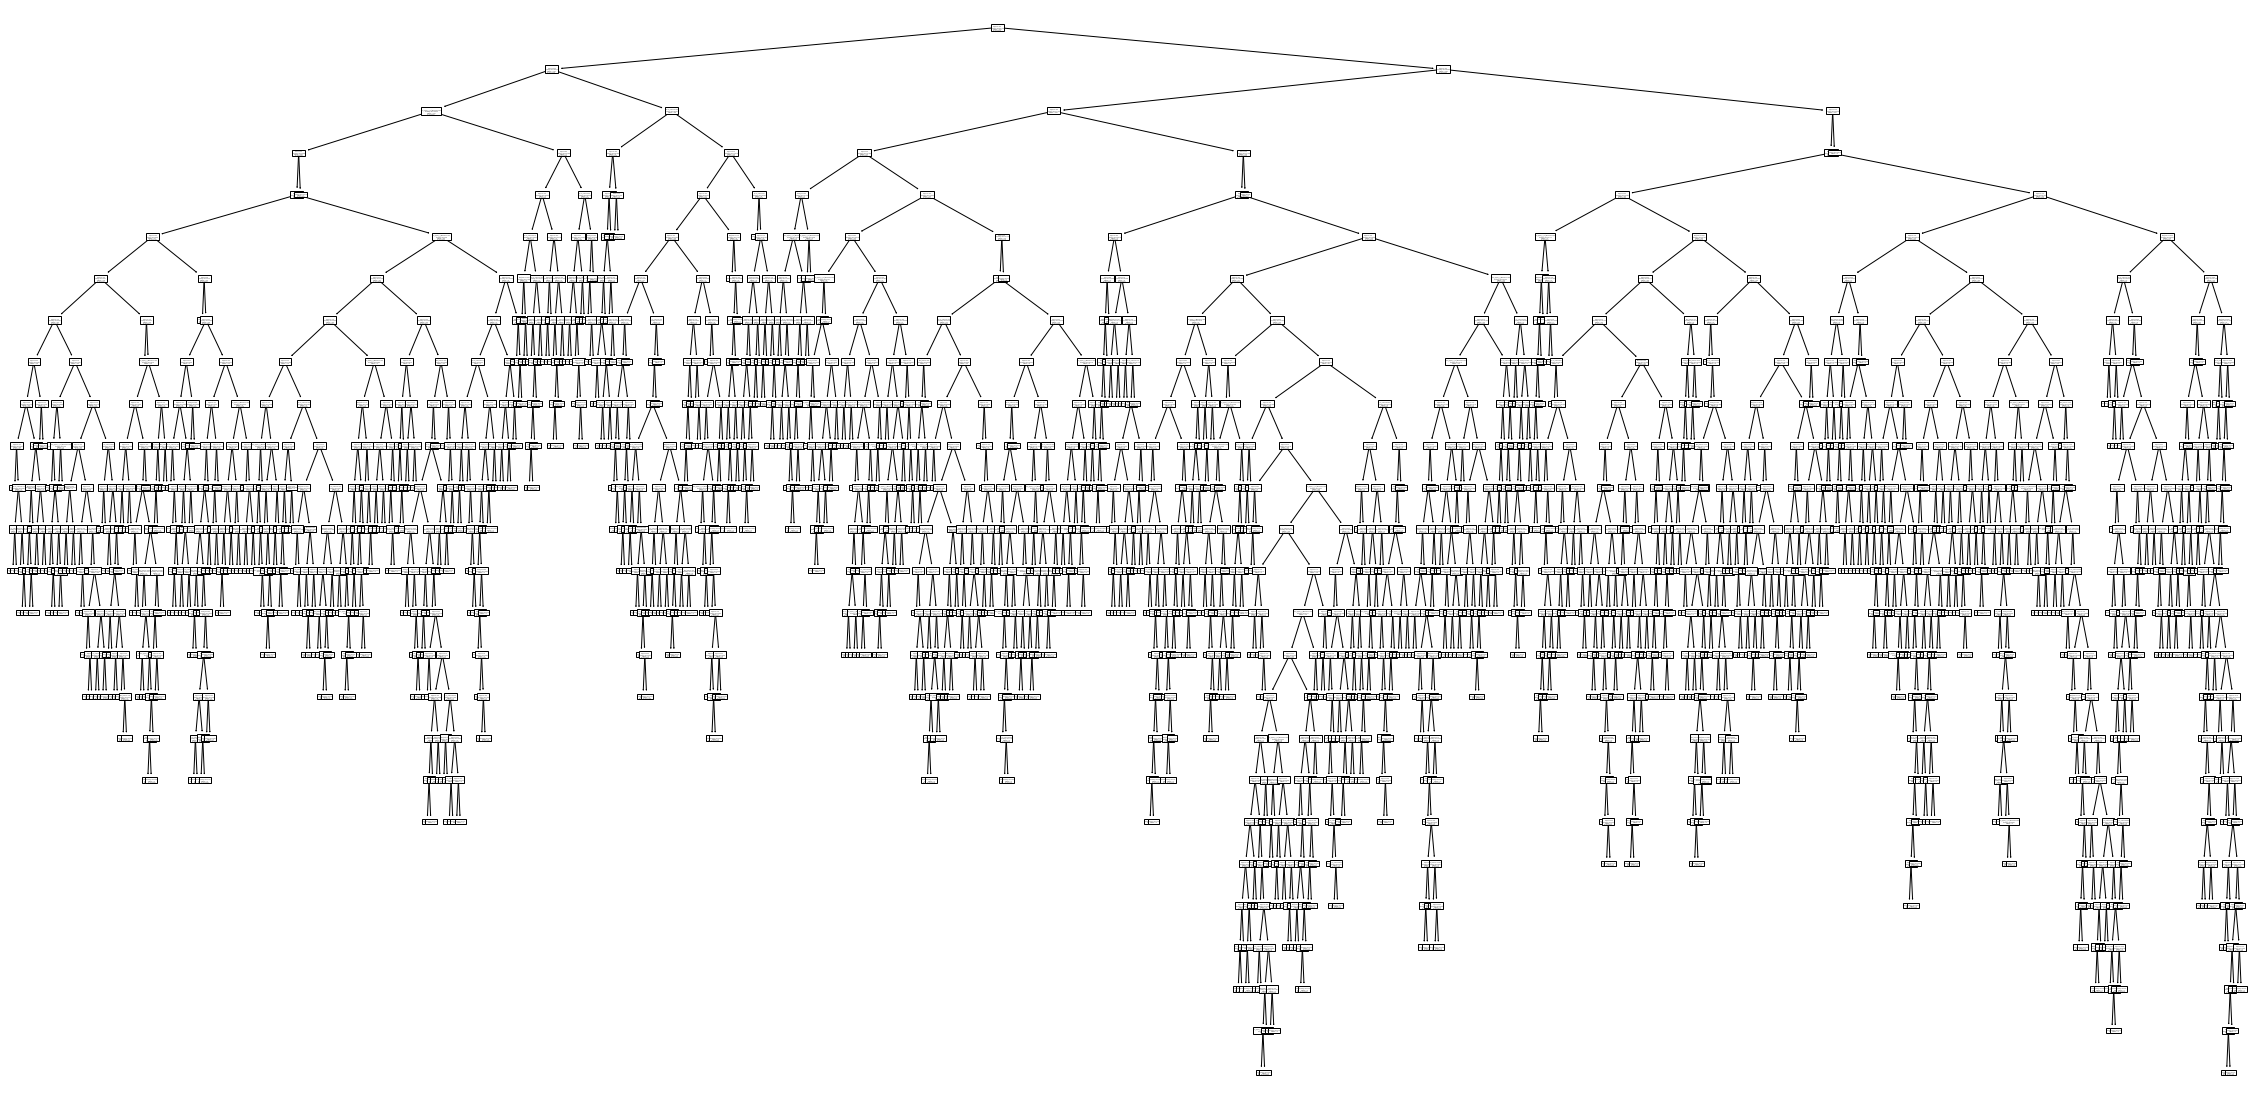

In [13]:
plt.figure(figsize=(40,20))
tree.plot_tree(RFR.best_estimator_.estimators_[0], feature_names = X.columns)
plt.show()

The feature with the highest importance is lag_24, the demand variable one day before the hour to be forecast.

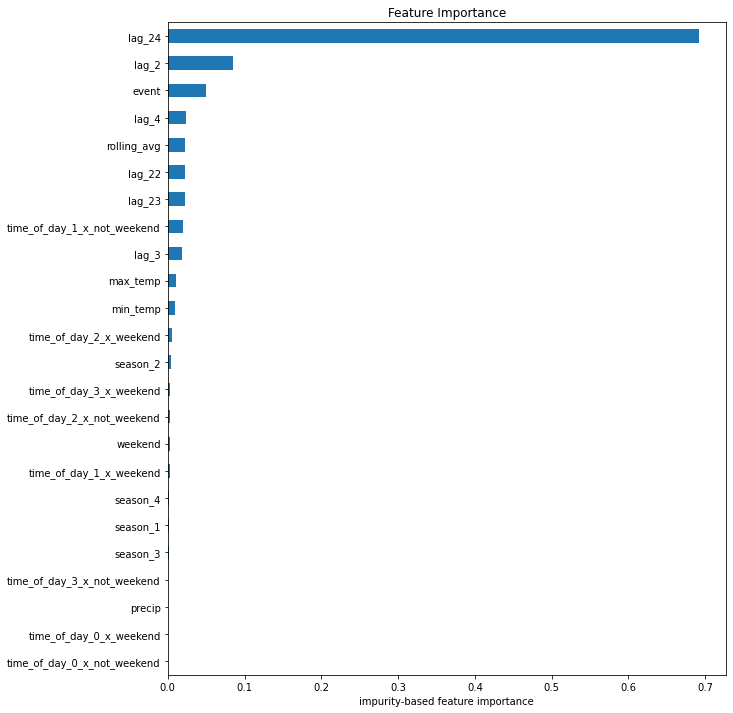

In [14]:
feat_importances = pd.Series(RFR.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("impurity-based feature importance")

plt.show()

### XGBoost

We use XGBoost, a gradient boosting algorithm with decision trees, as the second regression model. We choose XGBoost because the model has a built-in regularization option that reduces overfitting. Another advantage of XGBoost is its ability to capture nonlinear relationships.<br> A disadvantage of XGBoost is that it is sensitive to outliers because it builds trees on previous residuals, with are larger for outliers.<br><br>

**n_estimators:** number of trees <br>
**max_depth:** maximum tree depth <br>
**min_child_weight:** minimum sum of instance weight needed in a child<br>
**gamma:** minimum loss reduction needed to further split a node.<br>
**subsample:** fraction of instances sampled for each tree <br>
**colsample_bytree:** fraction of columns sampled for each tree <br>
**reg_alpha:** L1 regularization term on weights

In [15]:
model = xgb.XGBRegressor(random_state=42)
param_grid = {
 'max_depth': [2,3,4,5,6],
 'min_child_weight': [0,0.001,0.01],
}
params1 = find_params(param_grid,model,X_train,y_train).best_params_

model = xgb.XGBRegressor(random_state=42, **params1)
param_grid = {
 'gamma': [0.0, 0.001, 0.005, 0.01],
 'subsample': [0.8, 0.85, 0.9, 0.95, 1],
}
params2 = {**params1, **(find_params(param_grid,model,X_train,y_train).best_params_)}

model = xgb.XGBRegressor(random_state=42, **params2)
param_grid = {
 'colsample_bytree': [0.85, 0.9, 0.95, 1],
 'reg_alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1],
}
params3 = {**params2, **(find_params(param_grid,model,X_train,y_train).best_params_)}

model = xgb.XGBRegressor(random_state=42, **params3)
param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150]
}

XGB = find_params(param_grid, model, X_train, y_train)

score:  0.8424568742616394
best parameters:  {'max_depth': 5, 'min_child_weight': 0}
score:  0.8424568742616394
best parameters:  {'gamma': 0.0, 'subsample': 1}
score:  0.8455757634488444
best parameters:  {'colsample_bytree': 1, 'reg_alpha': 0.5}
score:  0.8469560788972744
best parameters:  {'n_estimators': 75}


Of great importance are the lag and moving average variables, which represent past demand, and the maximum temperature feature. 

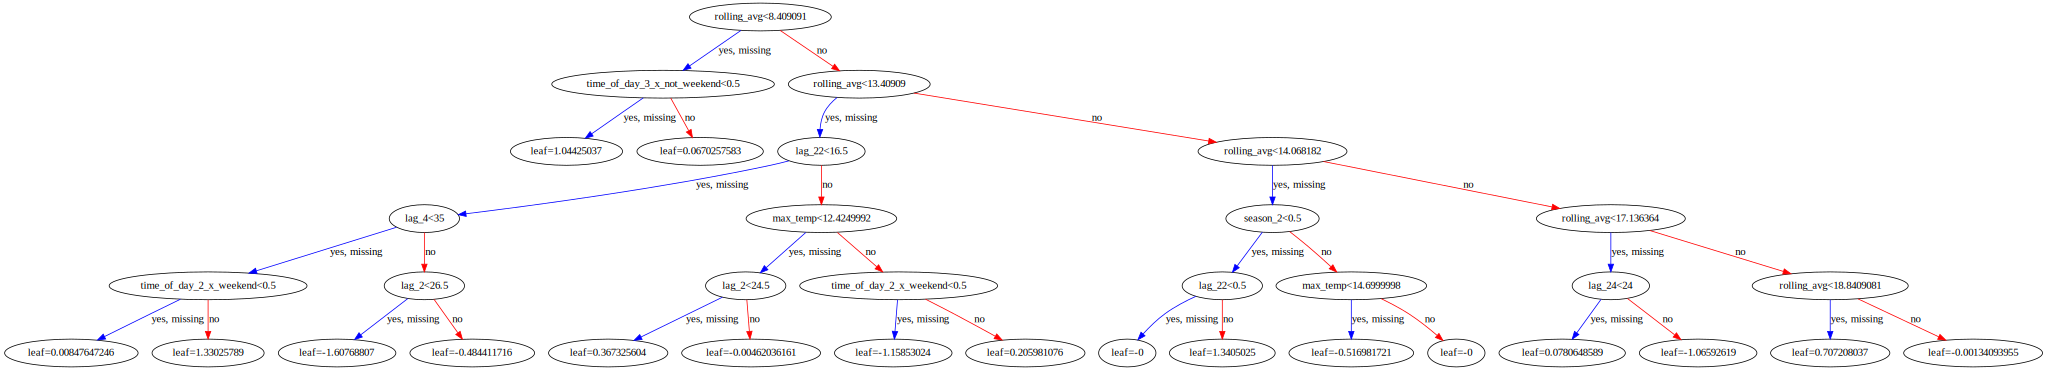

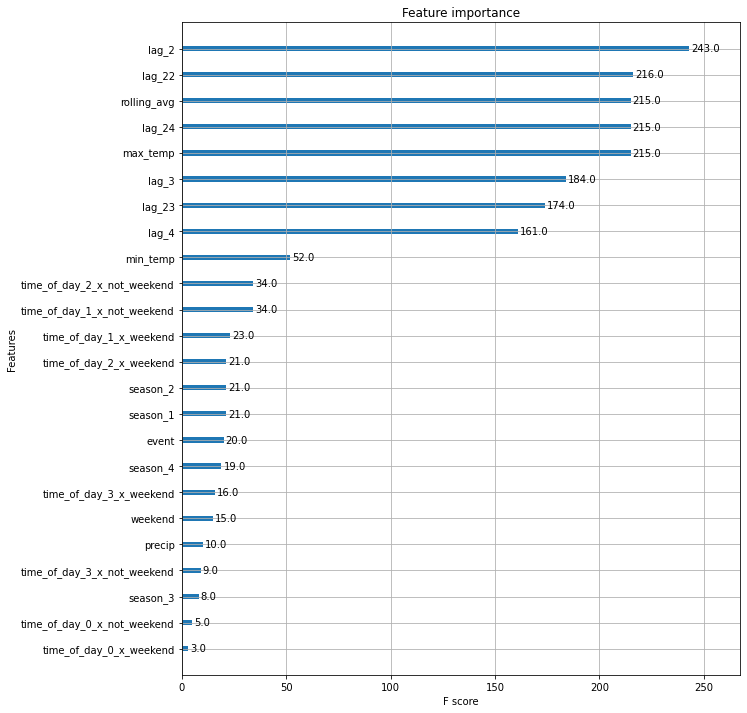

In [16]:
xgb.plot_importance(XGB.best_estimator_)
XGB_tree = xgb.to_graphviz(XGB.best_estimator_, num_trees=XGB.best_estimator_.best_iteration)
XGB_tree

### K-Nearest Neighbors

The last model we use for the prediction is a k-nearest neighbor regressor. We choose k-nearest neighbor because it is an un-parametic algoritm that does not make strong assumptions about fuction forms. The k-nearest neighbor regression can therefore capture nonlinear relationships in the dataset.<br> 
A disadvantage of the k-neareast neighbor regression is, that is is very sensitive to outliers as it works based on distance critera. The algorithm is also sensitive to the scale of input features.<br> 

We use the MinMaxScaler to ensure that all features lie on the same scale.

In [17]:
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)
X_scaled_df.head()

,max_temp,min_temp,precip,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,time_of_day_1_x_weekend,...,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend,event,lag_2,lag_3,lag_4,lag_22,lag_23,lag_24,rolling_avg
date_time,,,,,,,,,,,,,,,,,,,,,
2018-12-23 10:00:00,0.249135,0.254417,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.019737,0.026316,0.006579,0.128289,0.121711,0.075658,0.139936
2018-05-04 20:00:00,0.653979,0.667845,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.207237,0.319079,0.243421,0.032895,0.039474,0.108553,0.312585
2018-03-24 22:00:00,0.384083,0.392226,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.082237,0.148026,0.207237,0.032895,0.006579,0.049342,0.337119
2018-07-20 10:00:00,0.539792,0.551237,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.230263,0.128289,0.032895,0.250000,0.171053,0.118421,0.378464
2018-08-16 01:00:00,0.633218,0.646643,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.042763,0.052632,0.115132,0.000000,0.009868,0.013158,0.368923


We split the training set into a training set for training the k-nearest neighbor regressors and a validation set for tuning the hyperparameter n_neighbors.

In [18]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_scaled, y_train, test_size=0.3, random_state=42)

We select the hyperparameter n_neighbors, the number of neighbors used, using the elobw method.

Text(0, 0.5, 'Mean squared error')

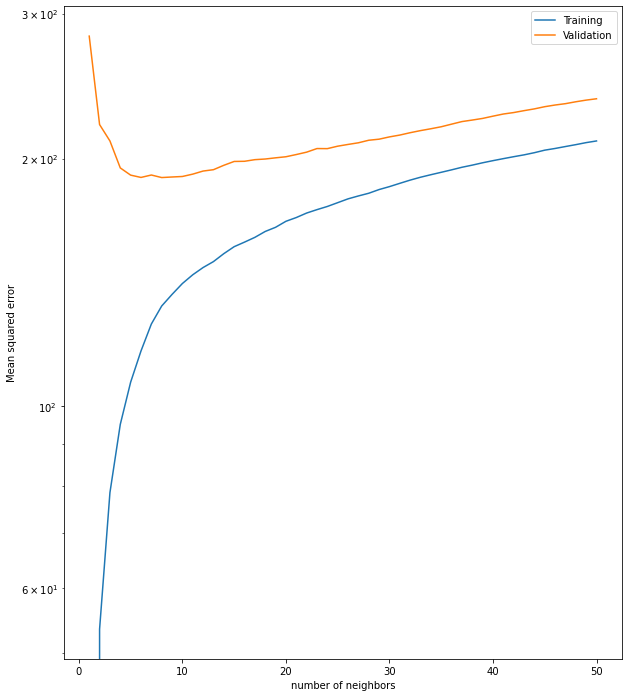

In [19]:
err_train = []
err_cv = []

for n in range(50):
    
    model = KNeighborsRegressor(n_neighbors = n+1)
    model.fit(X_train_2,y_train_2)
    
    pred_train = model.predict(X_train_2)
    err_train.append(mean_squared_error(y_train_2,pred_train))
    
    pred_val = model.predict(X_val)
    err_cv.append(mean_squared_error(y_val,pred_val))
    
plt.semilogy(range(1,51), err_train, range(1,51), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("number of neighbors")
plt.ylabel("Mean squared error")

(70, 350.0)

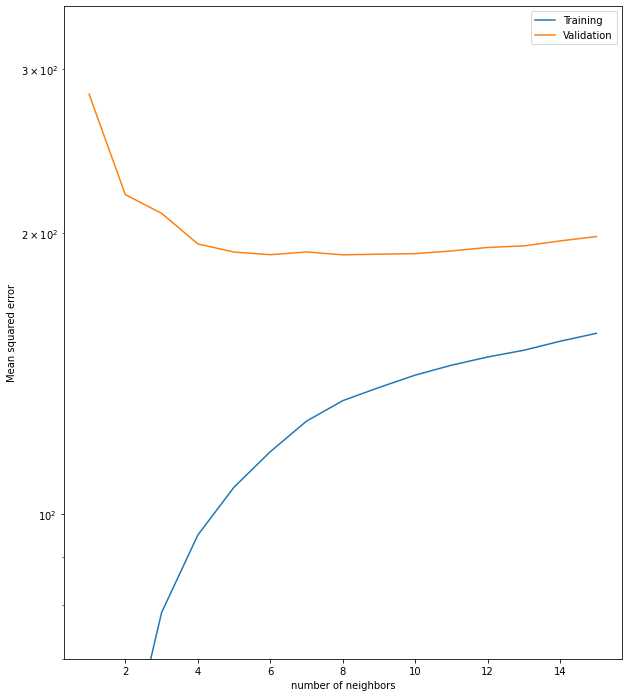

In [20]:
plt.semilogy(range(1,16), err_train[:15], range(1,16), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("number of neighbors")
plt.ylabel("Mean squared error")
plt.ylim([7*10**1,3.5*10**2])

From the two plots above, we expect  that a value of n_neighbors of four to be the best fit for our dataset.

In [21]:
KNN = KNeighborsRegressor(n_neighbors=4)
KNN.fit(X_scaled,y_train)

KNeighborsRegressor(n_neighbors=4)

## Model Evaluation

We evaluate our three regression models RandomForestRegressor, XGBoost and KNeighborsRegressor using three different evaluation metrics.<br> <br>
The first is the relative regression test metric R^2, which represents the proportion of the variance in the dependent variable demand that is accounted for by the model. Here, a horizontal line at the average value of the target variable would receive a R^2 value of zero.<br>
The other two test metrics we use are the absolute metrics Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). RMSE is the average squared difference between the predicted value and the true value of the target variable. The unit of RMSE is the same as the target variable. MAE is the average absolute derivation of the predicted from the true target variable.

In [22]:
def plot_true_vs_prediction(y_pred,y_test):
    
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80) 
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System-Level Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    # evaluation metrics
    print("R^2 score:",r2_score(y_test,y_pred))
    print("Root Mean Squared Error:",mean_squared_error(y_test,y_pred)**0.5)
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

As a result of the following evaluation of the three models, we would select XGBoost for deployment as it scores best in two out of three evaluation metrics.

### Random Forest

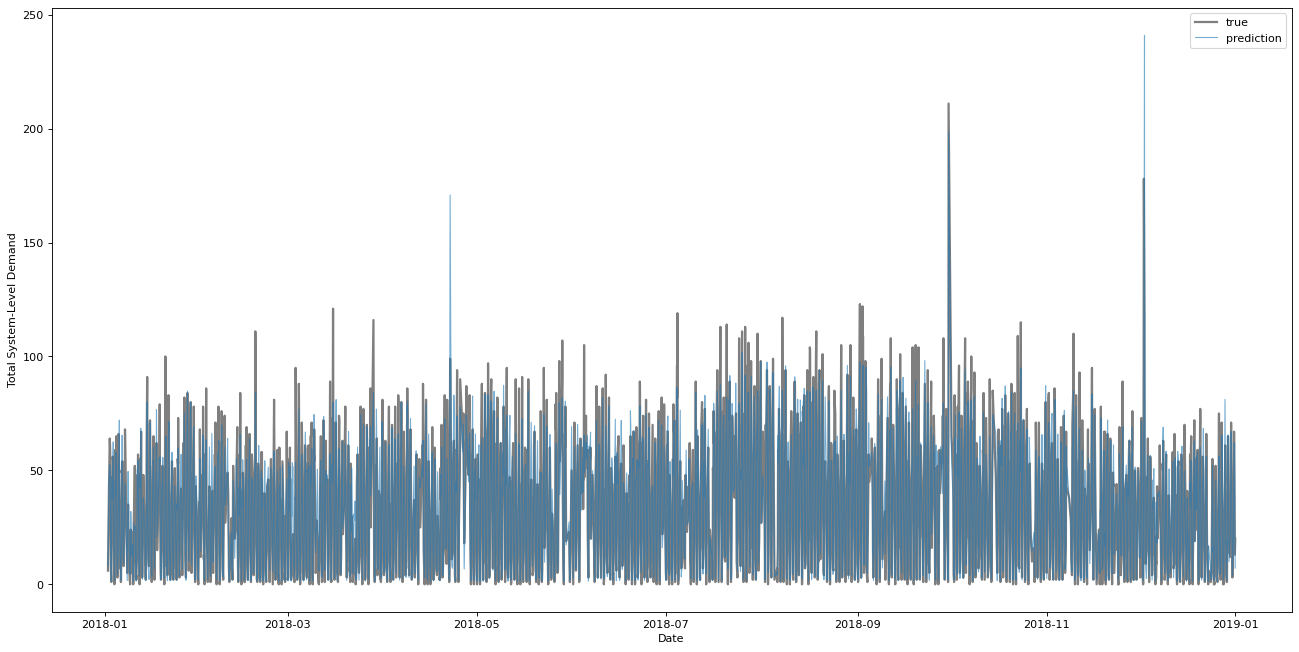

R^2 score: 0.8454110914613746
Root Mean Squared Error: 11.206876299523122
Mean Absolute Error: 7.482386354070703


In [23]:
y_pred_RFR = RFR.predict(X_test)

plot_true_vs_prediction(y_pred_RFR, y_test)

### XGBoost

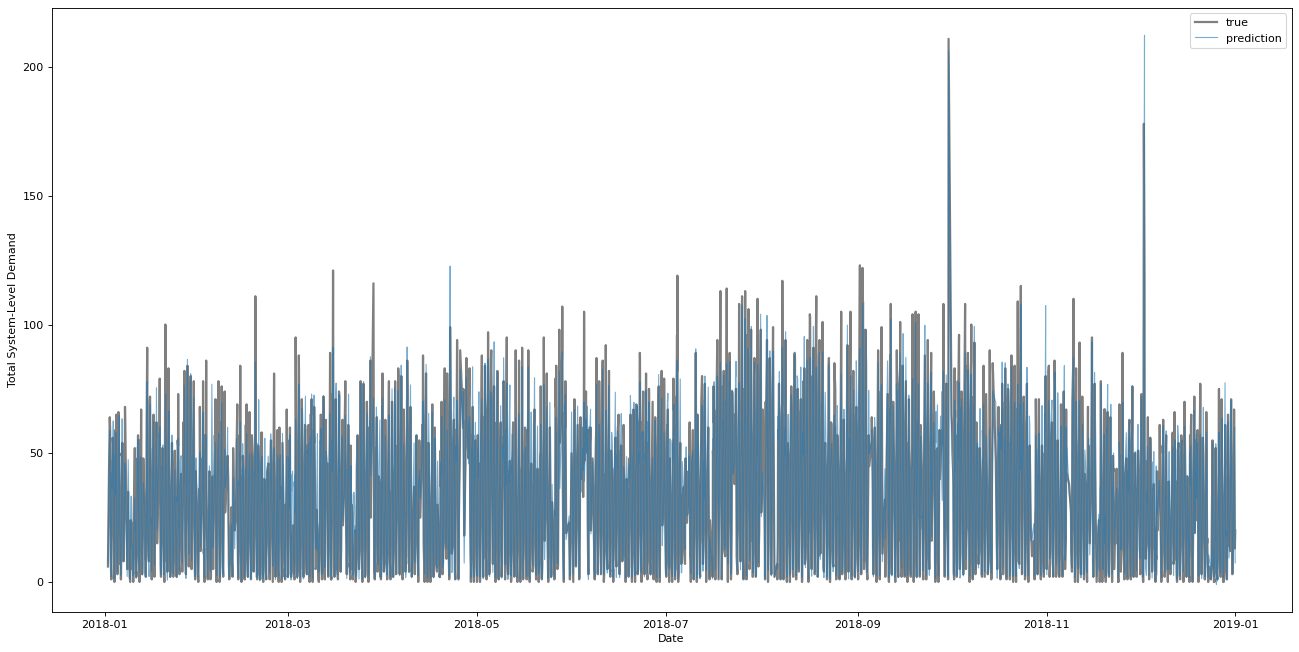

R^2 score: 0.8492239893636361
Root Mean Squared Error: 11.067805969877686
Mean Absolute Error: 7.610706682641376


In [24]:
y_pred_XGB = XGB.predict(X_test)

plot_true_vs_prediction(y_pred_XGB, y_test)

### K-Nearest Neighbors

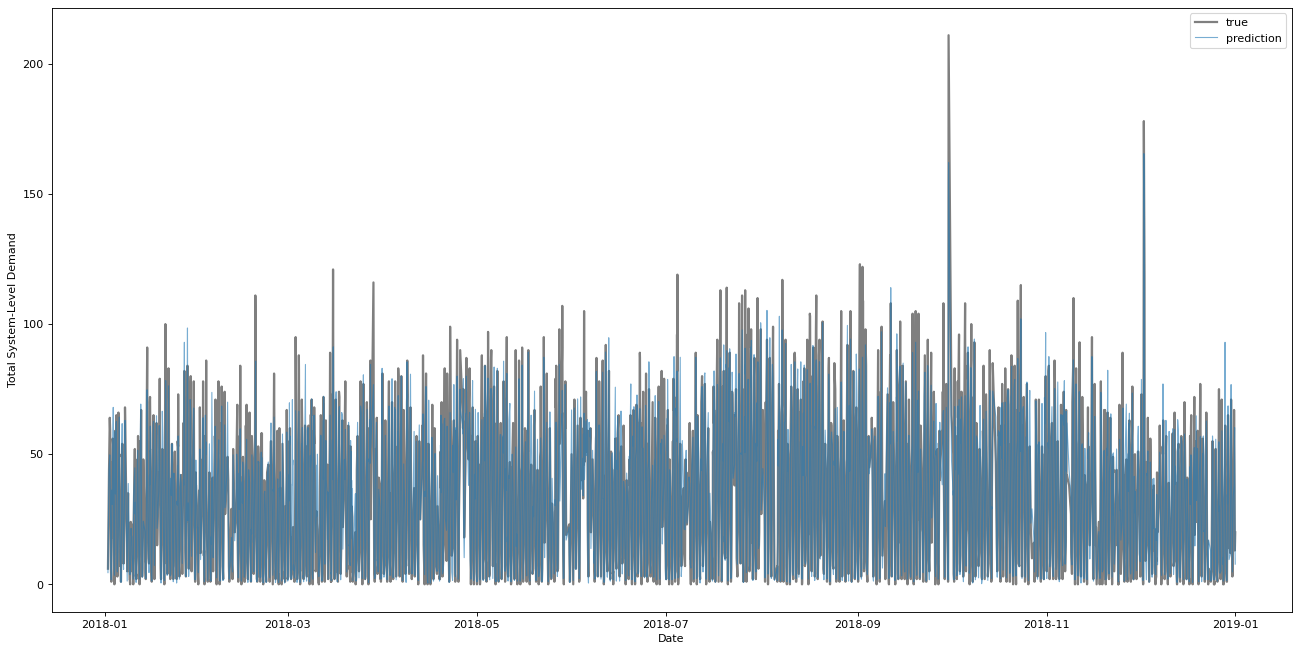

R^2 score: 0.834219931733268
Root Mean Squared Error: 11.605438911283823
Mean Absolute Error: 8.008107592521938


In [25]:
X_scaled_test=scaler.transform(X_test)

y_pred_KNN = KNN.predict(X_scaled_test)

plot_true_vs_prediction(y_pred_KNN,y_test)

## Outlook

The selected model XGBoost could be further improved by more hyperparameter tuning. We used only a fraction of the available hyperparameters to ensure reasonable computation time. The model can be further improved by tuning more of these available hyperparameters.<br>
We could also improve the model performance by including more and different input feartures in our estimation. This could include additional weather data such as wind velocity, that may impact bike demand. Our prediction includes a indicator for the event "CicLAvia". Other events in LA or public hollidays may also be associated with higher total system-level demand. Including these features in thedata set could also improve model performance. 